
# Кластеризація. Аналіз KMeans та DBSCAN
    

In [57]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# data = pd.read_csv("south+german+credit+update/SouthGermanCredit.asc", sep=" ", header=0)
df = pd.read_csv('south+german+credit+update/SouthGermanCredit.asc', sep='\\s+')

# Видалення всіх нечислових або нерелевантних колонок для кластеризації
df = df.select_dtypes(include=[np.number]).dropna()

# Відображення перших рядків таблиці
df.head()
    

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1



### Статистичний опис датасету

In [58]:
df.describe()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,...,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,...,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,...,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,...,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,...,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,...,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000



## Визначення оптимальної кількості кластерів

Щоб визначити оптимальну кількість кластерів для моделі кластеризації, ми використовуємо кілька підходів:

1. **Метод ліктя (Elbow Method)** — аналізує залежність Inertia (сума квадратів відстаней до найближчого центру кластера) від кількості кластерів.
2. **Метрика силуетів (Silhouette Score)** — оцінює якість кластеризації, вимірюючи, наскільки близько точки всередині одного кластера та наскільки далеко вони від точок інших кластерів. Значення метрики варіюється від -1 до 1, де 1 означає добре відокремлені кластери, 0 вказує на точки на межі кластерів, а негативні значення сигналізують про неправильне групування. Вона використовується для вибору оптимальної кількості кластерів, забезпечуючи баланс між компактністю та відокремленістю кластерів.
3. **Показник Калінського-Харабаза (Calinski-Harabasz Score)** — оцінює якість кластеризації, враховуючи співвідношення між розсіюванням точок всередині кластерів і відстанями між центрами кластерів. Чим більше значення цього показника, тим краще кластери компактні і добре відокремлені один від одного. Метрика є ефективною для порівняння різних алгоритмів або вибору оптимальної кількості кластерів.

### Візуалізація результатів для KMeans

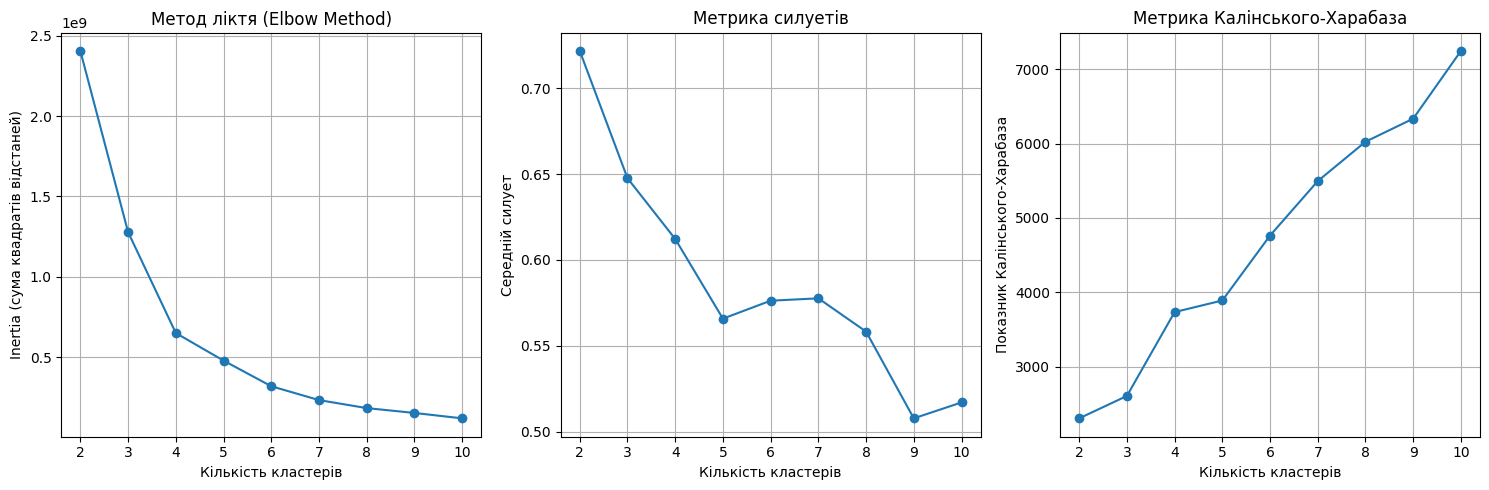

In [59]:
# Визначення оптимальної кількості кластерів
inertia_values = []
silhouette_scores = []
calinski_scores = []
range_n_clusters = range(2, 11)

# Обчислення метрик для різної кількості кластерів
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)  # Метрика Elbow (інерція)
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))  # Метрика силуетів
    calinski_scores.append(calinski_harabasz_score(df, kmeans.labels_))  # Показник Калінського-Харабаза

# Візуалізація метрик
plt.figure(figsize=(15, 5))

# Метод ліктя
plt.subplot(1, 3, 1)
plt.plot(range_n_clusters, inertia_values, marker='o', label="Elbow")
plt.xlabel("Кількість кластерів")
plt.ylabel("Inertia (сума квадратів відстаней)")
plt.title("Метод ліктя (Elbow Method)")
plt.grid()

# Метрика силуетів
plt.subplot(1, 3, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', label="Silhouette")
plt.xlabel("Кількість кластерів")
plt.ylabel("Середній силует")
plt.title("Метрика силуетів")
plt.grid()

# Показник Калінського-Харабаза
plt.subplot(1, 3, 3)
plt.plot(range_n_clusters, calinski_scores, marker='o', label="Calinski-Harabasz")
plt.xlabel("Кількість кластерів")
plt.ylabel("Показник Калінського-Харабаза")
plt.title("Метрика Калінського-Харабаза")
plt.grid()

plt.tight_layout()
plt.show()


- За методом ліктя оптимальна кількість кластерів — 4. На графіку видно, що після 4 кластерів крива стає більш пологою, тобто додавання кластерів дає незначне зменшення інерції. Ця точка зміни нахилу і є "ліктем", що вказує на оптимальну кількість кластерів.
- Метрика силуетів вказує, що найкраще розділення досягається при 2–3 кластерах. 
На графіку метрики силуетів найвище значення спостерігається при 2 кластерах, що означає найкраще розділення точок. Після 3 кластерів значення починає знижуватись, що вказує на погіршення відокремлення кластерів. Отже, 2–3 кластери забезпечують найкраще співвідношення компактності та відокремленості.
- Показник Калінського-Харабаза підтверджує оптимальність 4–5 кластерів. На графіку показника Калінського-Харабаза видно стрімке зростання до 4–5 кластерів, після чого темп збільшення уповільнюється. Це свідчить про те, що досягнуто оптимального балансу між компактністю та відокремленістю кластерів. Таким чином, 4–5 кластерів є найкращим вибором за цим показником.

### Візуалізація результатів для DBSCAN

In [60]:
# Визначення оптимальних параметрів для DBSCAN
eps_values = np.linspace(0.5, 5.0, 10)  # Кластеризація виконується з різними значеннями eps (радіус для сусідніх точок).
silhouette_scores_dbscan = []
calinski_scores_dbscan = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(df)
    print(f"eps={eps}, labels: {set(labels)}")

eps=0.5, labels: {np.int64(-1)}
eps=1.0, labels: {np.int64(-1)}
eps=1.5, labels: {np.int64(-1)}
eps=2.0, labels: {np.int64(-1)}
eps=2.5, labels: {np.int64(-1)}
eps=3.0, labels: {np.int64(-1)}
eps=3.5, labels: {np.int64(-1)}
eps=4.0, labels: {np.int64(-1)}
eps=4.5, labels: {np.int64(-1)}
eps=5.0, labels: {np.int64(-1)}


Результат labels: {np.int64(-1)} означає, що DBSCAN позначає всі точки як шум для всіх значень eps. Це може бути викликано тим, що точки розташовані дуже далеко одна від одної, і DBSCAN не може знайти достатньо щільних груп для формування кластерів 😭. Для вирішення цієї проблеми спробуємо нормалізуати ці дані.

In [61]:
# Масштабування даних
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


### Візуалізація результатів для DBSCAN

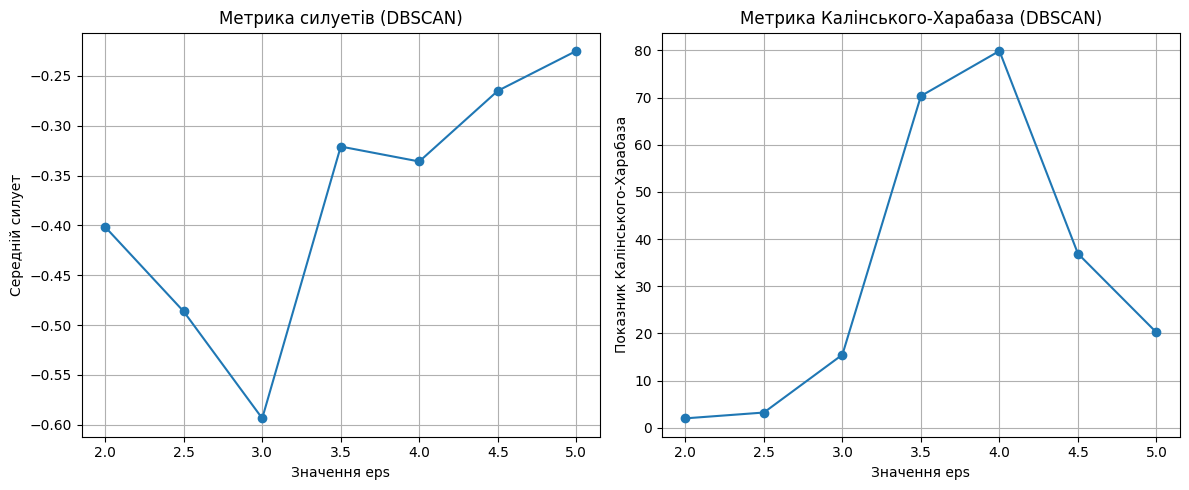

In [62]:
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)  # min_samples може бути змінений для інших результатів
    labels = dbscan.fit_predict(df_scaled)
    
    # Перевірка кількості кластерів (ігноруючи шум, позначений як -1)
    if len(set(labels)) > 1:  # Щоб уникнути помилок, коли всі точки в одному кластері або лише шум
        silhouette_scores_dbscan.append(silhouette_score(df, labels))
        calinski_scores_dbscan.append(calinski_harabasz_score(df, labels))
    else:
        silhouette_scores_dbscan.append(np.nan)
        calinski_scores_dbscan.append(np.nan)

# Візуалізація результатів
plt.figure(figsize=(12, 5))

# Метрика силуетів
plt.subplot(1, 2, 1)
plt.plot(eps_values, silhouette_scores_dbscan, marker='o', label="Silhouette (DBSCAN)")
plt.xlabel("Значення eps")
plt.ylabel("Середній силует")
plt.title("Метрика силуетів (DBSCAN)")
plt.grid()

# Показник Калінського-Харабаза
plt.subplot(1, 2, 2)
plt.plot(eps_values, calinski_scores_dbscan, marker='o', label="Calinski-Harabasz (DBSCAN)")
plt.xlabel("Значення eps")
plt.ylabel("Показник Калінського-Харабаза")
plt.title("Метрика Калінського-Харабаза (DBSCAN)")
plt.grid()

plt.tight_layout()
plt.show()



Оптимальне значення eps для DBSCAN, за обома метриками, становить приблизно 4.0. У цій точці кластеризація досягає найкращого балансу між компактністю кластерів і якістю їх розділення.